# Question Generator

<img src="img/QGenModel.png">

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy

## Load Word Embeddings

In [8]:
from torchtext.vocab import load_word_vectors

wv_dict, wv_arr, wv_size = load_word_vectors('.', 'glove.6B', 100)

print('Loaded', len(wv_arr), 'words')

loading word vectors from ./glove.6B.100d.pt
Loaded 400000 words


In [9]:
wv_dict['-SOS-'] = len(wv_dict)
temp = torch.cat([wv_arr, torch.randn((1,100))])
wv_arr = temp
wv_dict['-EOS-'] = len(wv_dict)
temp = torch.cat([wv_arr, torch.randn((1,100))])
wv_arr = temp

In [10]:
def get_wv(w):
    """ returning the word embedding """
    assert type(w) == str, "Not given a string."
    
    if w in wv_dict:
        vw = wv_arr[wv_dict[w]]
        return vw.view(1, 100)
    else:
        print('Word not in Vocab: %s' %(w))    

## Create Dummy Data

In [11]:
data = list()
data.append('-SOS- is it a person ? -EOS-')
data.append('-SOS- is it a dog ? -EOS-')
data.append('-SOS- is it on the left side ? -EOS-')
data.append('-SOS- is it on the ground ? -EOS-')
data.append('-SOS- is it in the sky ? -EOS-')
data.append('-SOS- is it an animal ? -EOS-')
data.append('-SOS- is it an apple ? -EOS-')
data.append('-SOS- is it red ? -EOS-')
data.append('-SOS- is it a cat ? -EOS-')
data.append('-SOS- is it on the right side ? -EOS-')
data.append('-SOS- is it at the top ? -EOS-')
data.append('-SOS- is it at the bottom ? -EOS-')
data.append('-SOS- is it blue ? -EOS-')
data.append('-SOS- are they in the foreground ? -EOS-')
data.append('-SOS- are they in the background ? -EOS-')
data.append('-SOS- are they wearing white ? -EOS-')
data.append('-SOS- are they wearing pants ? -EOS-')
data.append('-SOS- are they eating pizza ? -EOS-')
data.append('-SOS- are they eating a sandwich ? -EOS-')
data.append('-SOS- are they playing guitar ? -EOS-')

print(len(data))

20


## Prepare Data

In [12]:
vocab = set(' '.join(data).split())
word2index = dict()
index2word = dict()
for i, w in enumerate(vocab):
    word2index[w] = i
    index2word[i] = w
print(word2index)

{'top': 0, 'dog': 1, 'eating': 2, 'blue': 3, 'white': 4, 'person': 5, 'left': 6, 'the': 7, 'a': 8, '?': 9, 'in': 10, 'at': 11, 'right': 12, 'ground': 13, 'are': 14, 'sandwich': 15, 'it': 16, '-SOS-': 17, 'animal': 18, 'background': 19, 'side': 20, 'on': 21, 'sky': 22, 'cat': 23, '-EOS-': 24, 'foreground': 25, 'they': 26, 'red': 27, 'apple': 28, 'bottom': 29, 'pizza': 30, 'wearing': 31, 'is': 32, 'guitar': 33, 'pants': 34, 'playing': 35, 'an': 36}


## Model

### Hyperparameters

In [13]:
embedding_dim = 100
hidden_dim = 100
vocab_size = len(vocab)
target_size = len(vocab)
iterations = 10

In [14]:
class QGen(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(QGen, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to word space
        self.hidden2word = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence, hidden=None):
        
        if hidden == None:
            hidden = self.hidden
            
        # Word embedding of sentence
        embeds = autograd.Variable(torch.FloatTensor(len(sentence.split()), embedding_dim))

        for i, w in enumerate(sentence.split()):
            embeds[i] = get_wv(w)

        # lstm
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence.split()), 1, -1), hidden)
        
        
        # mapping hidden state to word output
        word_space = self.hidden2word(lstm_out.view(len(sentence.split()), -1))

        
        # p(w)
        word_scores = F.log_softmax(word_space)
        
        return word_scores, self.hidden

In [15]:
# Init Model, loss function and optimizer
model = QGen(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, target_size=target_size)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# See what the scores are before training
inputs = ' '.join(data[0].split()[:-1])
word_scores, _ = model(inputs)

avg_loss = []

for epoch in range(iterations):
    _loss = []
    
    for sentence in data:
        
        # clear gradients
        model.zero_grad()

        # clear hidden state for new datapoint
        model.hidden = model.init_hidden()

        # get the input to the LSTM
        sentence_in = ' '.join(sentence.split()[:-1])

        # get the desired output
        targets = autograd.Variable(torch.LongTensor(len(sentence.split())-1))
        for i, w in enumerate(sentence.split()[1:]):
            targets[i] = word2index[w]
            
            
        # run our forward pass.
        word_scores, _ = model(sentence_in)

        # compute loss and do SGD
        loss = loss_function(word_scores, targets)
        _loss.append(loss.data.numpy())
        loss.backward()
        optimizer.step()
        
    avg_loss.append(numpy.mean(_loss))
    
    
    print('Epoch %i Loss %f' %(epoch, avg_loss[-1]))
    
print('Training completed.')


Epoch 0 Loss 3.199958
Epoch 1 Loss 4.524344
Epoch 2 Loss 2.452382
Epoch 3 Loss 2.714814
Epoch 4 Loss 2.579645
Epoch 5 Loss 2.398459
Epoch 6 Loss 2.529383
Epoch 7 Loss 1.862185
Epoch 8 Loss 2.207916
Epoch 9 Loss 2.097496
Training completed.


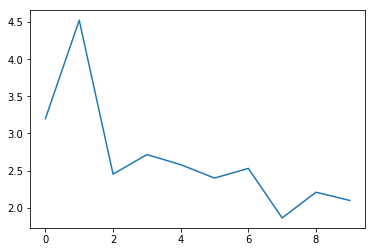

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_loss)
plt.show()

## Testing
Beam Search

In [17]:
# given the start of sentence token
# we use beam search to approximate the most likely question

inputs = '-SOS-'
h_init = model.init_hidden() # clear the first hidden state
max_lenght = 10 # max. question length
top_k = 3 # take the top k succesor word of the SOS token
p = [0]*3 # probability to track the sequence probability
seq = [inputs, inputs, inputs]


# get the first p(w) distribution
# do first forward pass 
input_wv = autograd.Variable(get_wv(inputs))
out, h_first = model.lstm(input_wv.view(1,1,-1), h_init)
word_space = model.hidden2word(out.view(1, -1))
word_score = F.log_softmax(word_space)
idxs = word_score.data.numpy().ravel().argsort()[-top_k:][::-1]

# get the top_k words and add them to the sequence
p = word_score.data.numpy().ravel()[idxs]
for i, idx in enumerate(idxs):
    seq[i]+= ' ' + index2word[idx]


for i, idx in enumerate(idxs):
    # get the first word and its embedding, set the hidden state
    inputs = index2word[idx]
    input_wv = autograd.Variable(get_wv(inputs))
    h = h_first
    
    # keep forward passing and keep track of sequence and respective probability
    for _ in range(1, max_lenght):
        out, h = model.lstm(input_wv.view(1,1,-1), h)
        word_space = model.hidden2word(out.view(1, -1))
        word_score = F.log_softmax(word_space)
        p[i] += numpy.max(word_score.data.numpy().ravel())
        inputs = index2word[numpy.argmax(word_score.data.numpy().ravel())]
        seq[i] += ' ' + inputs
        input_wv = autograd.Variable(get_wv(inputs))
        
        # if -EOS- was emitted, stop
        if inputs == '-EOS-':
            break
        
print(p)
print(seq)

[-2.07159686 -3.19004941 -9.78621769]
['-SOS- is they wearing pants ? -EOS-', '-SOS- are they wearing pants ? -EOS-', '-SOS- -EOS- it blue ? -EOS-']
